# Generating Dataset

In [8]:

'''
import cv2

cap = cv2.VideoCapture(0)

count1 = 250
count2 = 200
count3 = 200
count4 = 200
while(True):
    ret, frame = cap.read()
    cv2.imshow("Live Video", frame)


    if(cv2.waitKey(1) & 0xFF == ord('a')):
        count1 += 1
        cv2.imwrite(f"dataset/gesture_1/gesture_1_{count1}.jpg", frame)

    if(cv2.waitKey(1) & 0xFF == ord('b')):
        count2 += 1
        cv2.imwrite(f"dataset/gesture_2/gesture_2_{count2}.jpg", frame)

    if(cv2.waitKey(1) & 0xFF == ord('c')):
        count3 += 1
        cv2.imwrite(f"dataset/gesture_3/gesture_3_{count3}.jpg", frame)

    if(cv2.waitKey(1) & 0xFF == ord('d')):
        count4 += 1
        cv2.imwrite(f"dataset/gesture_4/gesture_4_{count4}.jpg", frame)

    if(cv2.waitKey(1) & 0xFF == ord('q')):
        cap.release()
        cv2.destroyAllWindows()
        break
'''

# Save Files in CSV

In [1]:
import os
import csv

# Base directory where the dataset is stored
base_dir = "dataset"

# Output CSV file
output_csv = "images.csv"

# Open the CSV file for writing
with open(output_csv, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    
    # Write the headers
    writer.writerow(["Path", "Label"])
    
    # Walk through the dataset directory
    for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)
        
        # Ensure it's a folder
        if os.path.isdir(folder_path):
            label = folder_name  # Use folder name as the label
            if folder_name == "gesture_1":
                label = "checazzo"
            if folder_name == "gesture_2":
                label = "peace"
            if folder_name == "gesture_3":
                label = "nice"
            if folder_name == "gesture_4":
                label = "nogesture"

            
            # Loop through each file in the folder
            for file_name in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file_name)
                
                # Ensure it's an image file (check extension)
                if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    # Write the relative path and label to the CSV
                    writer.writerow([file_path, label])

print(f"Images and labels have been saved to {output_csv}")

Images and labels have been saved to images.csv


# Initialize functions

In [2]:
import os
import pandas as pd
import torchvision
import torch
from torchvision import transforms

import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
from PIL import Image



class CustomImageDataset(Dataset):
    def __init__(self, root_dir,csv_file, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.class_to_idx = {cls: idx for idx, cls in enumerate(
            ['checazzo', 'peace', 'nice', 'nogesture'])}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_path)
        image = image.convert("RGB")


        label = self.annotations.iloc[idx, 1]
        label = self.class_to_idx[label]

        if self.transform:
            image = self.transform(image)
        
        return image, label

In [3]:
import cv2
import numpy as np
import random


class CustomTransform:
    def __init__(self):
        self.counter_rotation = 0
        self.counter_flipping = 0
        self.counter_blurring = 0
        self.counter_sharpening = 0
        self.counter_noise = 0
        self.counter_scale = 0

    def random_rotation(self, image):
        """Rotate the image by a random angle (45, 90, or 135 degrees) without changing colors."""
        # Reshape image to (height, width, channels)
        image = np.transpose(image, (1, 2, 0))  # Convert (3, 64, 64) to (64, 64, 3)
        rows, cols = image.shape[:2]
        
        # Randomly choose an angle: 45, 90, 135 or 180 degrees
        angle = random.choice([90,180,270])

        # Compute the rotation matrix
        M = cv2.getRotationMatrix2D(((cols - 1) / 2.0, (rows - 1) / 2.0), angle, 1)
        
        # Perform the rotation
        dst = cv2.warpAffine(image, M, (cols, rows))
        
        # Reshape image back to (channels, height, width)
        dst = np.transpose(dst, (2, 0, 1))  # Convert (64, 64, 3) back to (3, 64, 64)
        
        self.counter_rotation += 1
        return dst



    def random_flipping(self, image):
        """Flip the image randomly."""
        flip_code = random.choice([-1, 0, 1])  # -1: both axes, 0: vertical, 1: horizontal
        flipped = cv2.flip(image, flip_code)
        self.counter_flipping += 1
        return flipped

    def random_blurring(self, image):
        """Apply random Gaussian blur."""
        kernel_size = random.choice([3, 5, 7])  # Use smaller kernel sizes (3,5 or 7)
        blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
        self.counter_blurring += 1
        return blurred

    def random_sharpening(self, image):
        """Apply a sharpening kernel to the image."""
        kernel = np.array([[-1,-1,-1], 
                           [-1, 9,-1],
                           [-1,-1,-1]])  # Standard sharpening kernel
        sharpened = cv2.filter2D(image, -1, kernel) # Apply the sharpening kernel
        self.counter_sharpening += 1
        return sharpened

    def add_random_noise(self, image):
        """Add random Gaussian noise to an image with controlled intensity."""
        # Transpose image to (height, width, channels) if it's in (channels, height, width)
        image = np.transpose(image, (1, 2, 0))  # (3, 64, 64) to (64, 64, 3)
        
        row, col, ch = image.shape[:3]
        mean = 0
        var = random.uniform(0.001, 0.005)  # Randomly vary the variance (increase from before)
        sigma = var ** 0.5  # Standard deviation is the square root of variance
        
        # Generate Gaussian noise with the updated variance and sigma
        gauss = np.random.normal(mean, sigma, (row, col, ch))
        
        # Add the Gaussian noise to the image
        noisy = image + gauss

        # Clip the image to ensure pixel values are between 0 and 255
        #noisy = np.clip(noisy, 0, 255).astype(np.uint8)

        # Transpose back to (3, 64, 64)
        noisy_image = np.transpose(noisy, (2, 0, 1))  # (64, 64, 3) to (3, 64, 64)

        self.counter_noise += 1
        return noisy_image
    
    def random_scaling(self, image):
        # Transpose to HWC for OpenCV operations
        image = np.transpose(image, (1, 2, 0))  # CHW -> HWC

        # Scale the image by a random factor between 0.7 and 1.5
        scaling_zoom_factor = random.uniform(0.7, 1.5)
        scaled_image = cv2.resize(image, None, fx=scaling_zoom_factor, fy=scaling_zoom_factor, interpolation=cv2.INTER_LINEAR)

        # Resize back to (128, 128)
        scaled_image = cv2.resize(scaled_image, (128, 128))

        # Ensure the image has 3 channels
        if scaled_image.shape[-1] != 3:
            scaled_image = cv2.cvtColor(scaled_image, cv2.COLOR_GRAY2RGB)

        # Transpose back to CHW for PyTorch
        scaled_image = np.transpose(scaled_image, (2, 0, 1))  # HWC -> CHW

        self.counter_scale += 1
        return scaled_image



    
    # Apply random augmentations
    def __call__(self, image):
        """Apply a random combination of augmentations."""
        augmentations = [
            self.random_rotation,
            self.random_flipping,
            self.random_blurring,
            self.random_sharpening,
            self.add_random_noise
        ]
        random.shuffle(augmentations)  # Shuffle the order of augmentations
    
        # Apply only the first transformation from the shuffled list
        transformed = augmentations[0](image)
        # Apply scaling to transformed image and resize the image to 128x128 so it has channel 3, 128,128
        scaled_transformed = self.random_scaling(image)
    
        return transformed, scaled_transformed, self.counter_rotation, self.counter_flipping, self.counter_blurring, self.counter_sharpening, self.counter_noise, self.counter_scale  # Return the image and the augmentation counters


In [4]:
import os
import numpy as np
import torch
from PIL import Image
import random
import shutil

# Augment Dataset with Labels and Save Images
def augment_and_add_to_dataset(dataset, transform, num_augmentations=1, save_dir='augmented_dataset'):
    """
    Augment the dataset by applying transformations to each image
    and appending the augmented images with the same labels to the dataset.
    Saves the augmented images in class-specific directories.

    Args:
        dataset: The original dataset (CustomImageDataset or similar).
        transform: The transformation class with custom augmentation functions.
        num_augmentations: Number of augmented versions to create per image.
        save_dir: Root directory where augmented images will be saved.

    Returns:
        Augmented dataset (list of tuples with image tensor and label).
    """
    counter_rotation = 0
    counter_flipping = 0
    counter_blurring = 0
    counter_sharpening = 0
    counter_noise = 0
    counter_scaling = 0



       # Clear the directory if it exists
    if os.path.exists(save_dir):
        shutil.rmtree(save_dir)  # Delete everything inside the folder
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  # Create the base directory for augmented dataset

    augmented_data = []

    for idx in range(len(dataset)):
        image, label = dataset[idx]
        
        # Convert tensor back to numpy for transformation
        original_image = image.squeeze(0).numpy()
        #print(original_image.shape)
        # Add the original image and label
        augmented_data.append((image, label))

        # Create class-specific directory if it doesn't exist
        class_dir = os.path.join(save_dir, f'class_{label}')
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        # Save the original image
        save_image(original_image, class_dir, num_augmentations, 'original')

        # Create augmented versions and save them
        for i in range(num_augmentations):
            augmented_image, scaled, counter_rotation,counter_flipping, counter_blurring, counter_sharpening, counter_noise, counter_scaling = transform(original_image)
            augmented_image_tensor = torch.tensor(augmented_image)
            scaled = torch.tensor(scaled)
            # Save augmented image
            save_image(augmented_image, class_dir,num_augmentations, f'aug_{i + 1}')
            #print(augmented_image.shape)
            augmented_data.append((augmented_image_tensor, label))
            augmented_data.append((scaled, label))

     # Apply only the first transformation from the shuffled list
    print("Counter rotation: ", counter_rotation)
    print("Counter flipping: ", counter_flipping)
    print("Counter blurring: ", counter_blurring)
    print("Counter sharpening: ", counter_sharpening)
    print("Counter noise: ", counter_noise)
    print("Counter scaling: ", counter_scaling)
    return augmented_data


def save_image(image, class_dir, num_augmentations, suffix):
    """
    Save the image to the specified directory with the given suffix.
    """
    
    # If the image has shape (channels, height, width), transpose to (height, width, channels)
    if image.ndim == 3 and image.shape[0] == 3:
        image = np.transpose(image, (1, 2, 0))
    
    # Convert to uint8 if necessary
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8

    #print(f"Processed image shape: {image.shape}, dtype: {image.dtype}")

    # Convert the numpy array to a PIL image
    pil_image = Image.fromarray(image)

    # Create a unique filename for each image
    filename = f"{suffix}_{random.randint(0, 1000)}.jpg"  # Adding randomness to avoid overwriting

    # Save the image in the class directory
    pil_image.save(os.path.join(class_dir, filename))





In [5]:
seed = 42
generator = torch.Generator().manual_seed(seed)

current_dir = os.getcwd()
print(f"Current directory: {current_dir}")


classes = ('checazzo', 'peace', 'nice', 'nogesture')

# Set up transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)), # Resize the image to 32x32
    transforms.ToTensor(),  # Converts to tensor of shape [1, H, W]
    ])

# Instantiate custom transformation
custom_transform_100 = CustomTransform()
custom_transform_200 = CustomTransform()
custom_transform_300 = CustomTransform()

# Create dataset
original_dataset = CustomImageDataset(csv_file='images.csv', root_dir=os.getcwd(), transform=transform)
print(f"Original dataset size: {len(original_dataset)}")
# Split dataset into 80% train and 20% test
train_size_original = int(0.8 * len(original_dataset))
test_size_original = len(original_dataset) - train_size_original
train_set_original, test_set_original = random_split(original_dataset, [train_size_original, test_size_original],generator=generator)
# Create DataLoaders
train_loader_original = DataLoader(train_set_original, batch_size=32, shuffle=True)
test_loader_original = DataLoader(test_set_original, batch_size=32, shuffle=False)


# Augment the dataset by 100 images per class
num_augmentations_100 = 1  # Number of augmented versions per original image
dataset_100 = augment_and_add_to_dataset(train_set_original, custom_transform_100, num_augmentations_100, save_dir='augmented_dataset100')
print(f"Augmented dataset size: {len(dataset_100)}")
# Split dataset into 80% train and 20% 
train_size_100 = int(0.8 * len(dataset_100))
test_size_100 = len(dataset_100) - train_size_100
#train_set_100, test_set_100 = random_split(dataset_100, [train_size_100, test_size_100],generator=generator)
# Create DataLoaders
train_loader_100 = DataLoader(dataset_100, batch_size=32, shuffle=True)
#test_loader_100 = DataLoader(test_set_100, batch_size=32, shuffle=False)

# Augment the dataset by 200 images per class
num_augmentations_200 = 2  # Number of augmented versions per original image
dataset_200 = augment_and_add_to_dataset(train_set_original, custom_transform_200, num_augmentations_200, save_dir='augmented_dataset200')
print(f"Augmented dataset size: {len(dataset_200)}")
# Split dataset into 80% train and 20% test
train_size_200 = int(0.8 * len(dataset_200))
test_size_200 = len(dataset_200) - train_size_200
#train_set_200, test_set_200 = random_split(dataset_200, [train_size_200, test_size_200],generator=generator)
# Create DataLoaders
train_loader_200 = DataLoader(dataset_200, batch_size=32, shuffle=True)
#test_loader_200 = DataLoader(test_set_200, batch_size=32, shuffle=False)


# Augment the dataset by 300 images per class
num_augmentations_300 = 3  # Number of augmented versions per original image
dataset_300 = augment_and_add_to_dataset(train_set_original, custom_transform_300, num_augmentations_300, save_dir='augmented_dataset300')
print(f"Augmented dataset size: {len(dataset_300)}")
# Split dataset into 80% train and 20% test
train_size_300 = int(0.8 * len(dataset_300))
test_size_300 = len(dataset_300) - train_size_300
#train_set_300, test_set_300 = random_split(dataset_300, [train_size_300, test_size_300],generator=generator)
# Create DataLoaders
train_loader_300 = DataLoader(dataset_300, batch_size=32, shuffle=True)
#test_loader_300 = DataLoader(test_set_300, batch_size=32, shuffle=False)



Current directory: /home/andiv/OneDrive/UIBK/Semester5/VisualComputing/Visual-Project
Original dataset size: 564
Counter rotation:  84
Counter flipping:  86
Counter blurring:  92
Counter sharpening:  95
Counter noise:  94
Counter scaling:  451
Augmented dataset size: 1353
Counter rotation:  176
Counter flipping:  183
Counter blurring:  202
Counter sharpening:  172
Counter noise:  169
Counter scaling:  902
Augmented dataset size: 2255
Counter rotation:  283
Counter flipping:  285
Counter blurring:  272
Counter sharpening:  239
Counter noise:  274
Counter scaling:  1353
Augmented dataset size: 3157


In [6]:
# Function to show images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()

    # Remove extra singleton dimensions (1, 1, 3, 32, 32) => (3, 32, 32)
    npimg = np.squeeze(npimg)  # Remove the extra singleton dimensions

    # If the image has 3 channels (RGB), we can directly display it
    if npimg.shape[0] == 3:
        npimg = np.transpose(npimg, (1, 2, 0))  # Transpose to (32, 32, 3) for RGB format

    plt.imshow(npimg)  # Show the image with RGB channels
    plt.show()
    

# Get some random training images

#dataset_iter = iter(train_loader_original)
#images, labels = next(dataset_iter)

"""# Loop through each image in the batch
for i, image in enumerate(images):
    print(f"Image {i + 1}")
    imshow(image)
    print(f"Label: {classes[labels[i].item()]}")"""

'# Loop through each image in the batch\nfor i, image in enumerate(images):\n    print(f"Image {i + 1}")\n    imshow(image)\n    print(f"Label: {classes[labels[i].item()]}")'

# CNN

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

##CNN Architecture

#Generally the CNN output size can be calculated as follows (for an image with same height and width dimensions):
#output_size = ((input_size - kernel_size + 2*padding) / stride) + 1

#Since we transform each image to grayscale we have 1 input channel.
# Also we use padding, because the most relevant informations lie in the center of the images.csv

#input size of each image: 128x128

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, padding=1) #output size = 124x124
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, padding=1) #output size = 60*60
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1) #output size = 30*30
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, padding=1) #output size = 14*14
        #self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        #self.conv6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        # Pooling layer for downsampling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout layers for regularization
        self.dropout = nn.Dropout(0.5)


        # Fully connected layers
        self.fc1 = nn.Linear(64*7*7, 1000)
        self.fc2 = nn.Linear(1000, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 64)
        self.fc5 = nn.Linear(64, 4) #4 output classes 3 gestures and 1 for no gesture

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # output size = 62*62
        x = self.pool(F.relu(self.conv2(x))) # output size = 30*30
        x = self.pool(F.relu(self.conv3(x))) #output size = 15*15
        x = self.pool(F.relu(self.conv4(x))) # output size = 7*7

       # x = F.relu(self.conv5(x)) #output size = 8x8
       # x = self.pool(F.relu(self.conv6(x))) # output size = 4x4

        x = x.view(-1, 64*7*7)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = self.fc5(x) #no activation function because we use CrossEntropyLoss

        return x

In [8]:
#Hyperparameters
LEARNING_RATE = 0.001
EPOCHS = 50

# Check if the GPU is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print(device)


model_original = Net()
optimizer_original = torch.optim.Adam(model_original.parameters(), lr=LEARNING_RATE)

model_100 = Net()
optimizer_100 = torch.optim.Adam(model_100.parameters(), lr=LEARNING_RATE)

model_200 = Net()
optimizer_200 = torch.optim.Adam(model_200.parameters(), lr=LEARNING_RATE)

model_300 = Net()
optimizer_300 = torch.optim.Adam(model_300.parameters(), lr=LEARNING_RATE)


criterion = nn.CrossEntropyLoss()

print(model_original)


cpu
Net(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3136, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=4, bias=True)
)


In [10]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [11]:
from torchsummary import summary

summary(model_original, (3, 128, 128)) # (channels, height, width of input image)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 126, 126]             608
         MaxPool2d-2            [-1, 8, 63, 63]               0
            Conv2d-3           [-1, 16, 61, 61]           3,216
         MaxPool2d-4           [-1, 16, 30, 30]               0
            Conv2d-5           [-1, 32, 30, 30]           4,640
         MaxPool2d-6           [-1, 32, 15, 15]               0
            Conv2d-7           [-1, 64, 14, 14]          32,832
         MaxPool2d-8             [-1, 64, 7, 7]               0
            Linear-9                 [-1, 1000]       3,137,000
          Dropout-10                 [-1, 1000]               0
           Linear-11                  [-1, 512]         512,512
          Dropout-12                  [-1, 512]               0
           Linear-13                  [-1, 256]         131,328
          Dropout-14                  [

In [12]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [9]:

def train(model, train_loader, optimizer, criterion, n_epochs=None):
    model.train()
    losses = []
    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(train_loader,0):
        
        #get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = inputs.float()
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            loss_value = loss.item()
            losses.append(loss_value)
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}, loss: {running_loss / len(train_loader)}")

    print('Finished Training')
    return losses


Epoch 1, loss: 1.3860716183980306
Epoch 2, loss: 1.387516442934672
Epoch 3, loss: 1.3893212874730427
Epoch 4, loss: 1.389011836051941
Epoch 5, loss: 1.375285808245341
Epoch 6, loss: 1.399778127670288
Epoch 7, loss: 1.3804437478383382
Epoch 8, loss: 1.3706282695134482
Epoch 9, loss: 1.3516387859980266
Epoch 10, loss: 1.2844590187072753
Epoch 11, loss: 1.2263294140497842
Epoch 12, loss: 1.163347554206848
Epoch 13, loss: 1.0639445900917053
Epoch 14, loss: 1.0677579998970033
Epoch 15, loss: 0.9370220144589742
Epoch 16, loss: 1.006739087899526
Epoch 17, loss: 1.0079617063204447
Epoch 18, loss: 0.9537038286526998
Epoch 19, loss: 0.9363562345504761
Epoch 20, loss: 0.8770784099896749
Epoch 21, loss: 0.8468447327613831
Epoch 22, loss: 0.8638605197270711
Epoch 23, loss: 0.835422945022583
Epoch 24, loss: 0.9072604298591613
Epoch 25, loss: 0.8207002600034078
Epoch 26, loss: 0.7848697423934936
Epoch 27, loss: 1.026070503393809
Epoch 28, loss: 0.9609536369641621
Epoch 29, loss: 0.797150711218516
Epo

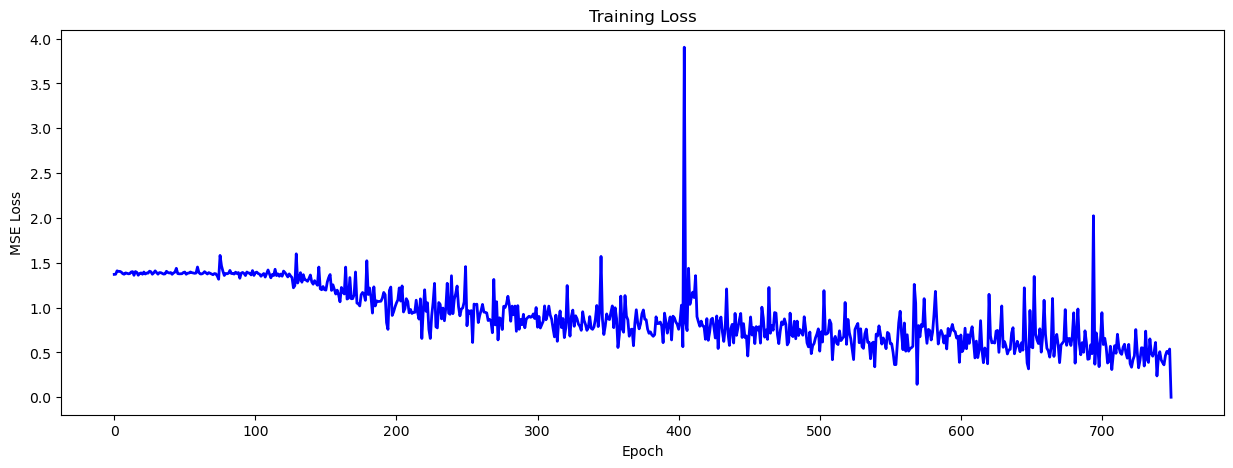

In [18]:
losses_original = train(model=model_original, train_loader=train_loader_original, optimizer=optimizer_original, criterion=criterion, n_epochs=EPOCHS)

plt.figure(figsize=(15, 5))
plt.plot(losses_original, lw=2,color='blue')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

# Save the trained model
PATH = './model_original.pth'
torch.save(model_original.state_dict(), PATH)

Epoch 1, loss: 1.3852532630742982
Epoch 2, loss: 1.371529681738033
Epoch 3, loss: 1.354539108830829
Epoch 4, loss: 1.2388412592022917
Epoch 5, loss: 1.152571669844694
Epoch 6, loss: 1.0614843035853185
Epoch 7, loss: 0.9974666251692661
Epoch 8, loss: 0.9621027915976769
Epoch 9, loss: 0.9492342763168867
Epoch 10, loss: 0.8540473802145138
Epoch 11, loss: 0.8051642359689225
Epoch 12, loss: 0.7272342055342919
Epoch 13, loss: 0.5942376456981482
Epoch 14, loss: 0.5768571087094241
Epoch 15, loss: 0.5465149117070575
Epoch 16, loss: 0.40917736257231513
Epoch 17, loss: 0.3244048176809799
Epoch 18, loss: 0.22828835898707078
Epoch 19, loss: 0.2929370646733184
Epoch 20, loss: 0.22958067925863487
Epoch 21, loss: 0.1659017040632492
Epoch 22, loss: 0.15104067514022423
Epoch 23, loss: 0.10055290855640589
Epoch 24, loss: 0.09768736791298833
Epoch 25, loss: 0.06842194876611926
Epoch 26, loss: 0.10526922418800898
Epoch 27, loss: 0.11664715803466565
Epoch 28, loss: 0.10405843766666083
Epoch 29, loss: 0.0571

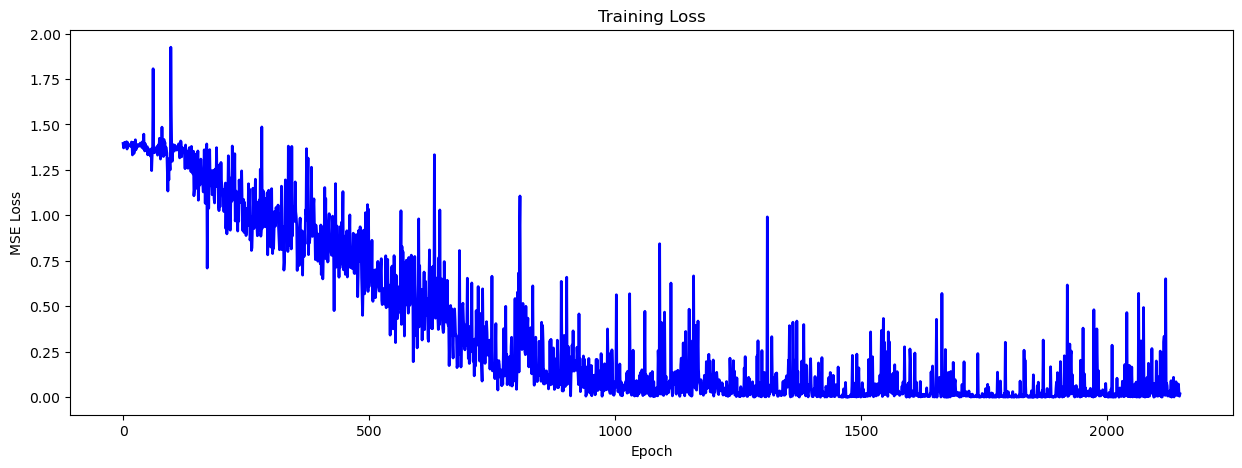

In [10]:
losses_100 = train(model=model_100, train_loader=train_loader_100, optimizer=optimizer_100, criterion=criterion, n_epochs=EPOCHS)

plt.figure(figsize=(15, 5))
plt.plot(losses_100, lw=2,color='blue')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

# Save the trained model
PATH = './model_100.pth'
torch.save(model_100.state_dict(), PATH)

Epoch 1, loss: 1.391273127475255
Epoch 2, loss: 1.3861003979830675
Epoch 3, loss: 1.367170293566207
Epoch 4, loss: 1.2591430914234107
Epoch 5, loss: 1.1104815954893408
Epoch 6, loss: 1.017926231236525
Epoch 7, loss: 0.9541634724173748
Epoch 8, loss: 0.8962910586679486
Epoch 9, loss: 0.8249652637562281
Epoch 10, loss: 0.637337712334915
Epoch 11, loss: 0.45934069534422645
Epoch 12, loss: 0.3227224570344871
Epoch 13, loss: 0.24597807438440725
Epoch 14, loss: 0.20311332095256993
Epoch 15, loss: 0.17230400692304254
Epoch 16, loss: 0.11812404467081519
Epoch 17, loss: 0.14608889015417703
Epoch 18, loss: 0.08476513410380608
Epoch 19, loss: 0.07847448260339737
Epoch 20, loss: 0.07763761000602808
Epoch 21, loss: 0.06052297767920708
Epoch 22, loss: 0.10385936279256473
Epoch 23, loss: 0.05087374125502374
Epoch 24, loss: 0.03774246284131512
Epoch 25, loss: 0.06532356499130247
Epoch 26, loss: 0.0861060546127371
Epoch 27, loss: 0.07138880642383477
Epoch 28, loss: 0.046189098241497126
Epoch 29, loss: 

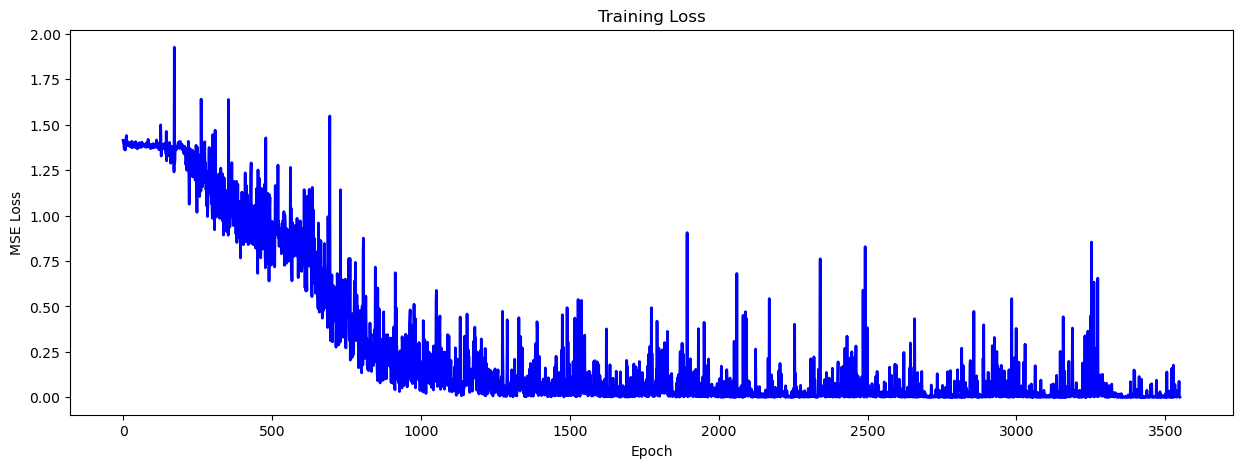

In [11]:
losses_200 = train(model=model_200, train_loader=train_loader_200, optimizer=optimizer_200, criterion=criterion, n_epochs=EPOCHS)

plt.figure(figsize=(15, 5))
plt.plot(losses_200, lw=2,color='blue')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

# Save the trained model
PATH = './model_200.pth'
torch.save(model_200.state_dict(), PATH)

Epoch 1, loss: 1.388034576177597
Epoch 2, loss: 1.3845992475748061
Epoch 3, loss: 1.3693145245313645
Epoch 4, loss: 1.3189059406518937
Epoch 5, loss: 1.2789430499076844
Epoch 6, loss: 1.2195644170045852
Epoch 7, loss: 1.0731984570622444
Epoch 8, loss: 1.0173810377717019
Epoch 9, loss: 0.9972016587853432
Epoch 10, loss: 0.943278868496418
Epoch 11, loss: 0.9284340545535088
Epoch 12, loss: 0.836428590118885
Epoch 13, loss: 0.757767403125763
Epoch 14, loss: 0.6808727577328682
Epoch 15, loss: 0.59834353774786
Epoch 16, loss: 0.5812031529843807
Epoch 17, loss: 0.4929362051188946
Epoch 18, loss: 0.4610076565295458
Epoch 19, loss: 0.3904554594308138
Epoch 20, loss: 0.3025615932419896
Epoch 21, loss: 0.28478250075131656
Epoch 22, loss: 0.2620136125013232
Epoch 23, loss: 0.2401901876553893
Epoch 24, loss: 0.22577524594962597
Epoch 25, loss: 0.22666946165263652
Epoch 26, loss: 0.18076306949369608
Epoch 27, loss: 0.1703400758560747
Epoch 28, loss: 0.13765596402809024
Epoch 29, loss: 0.142906531179

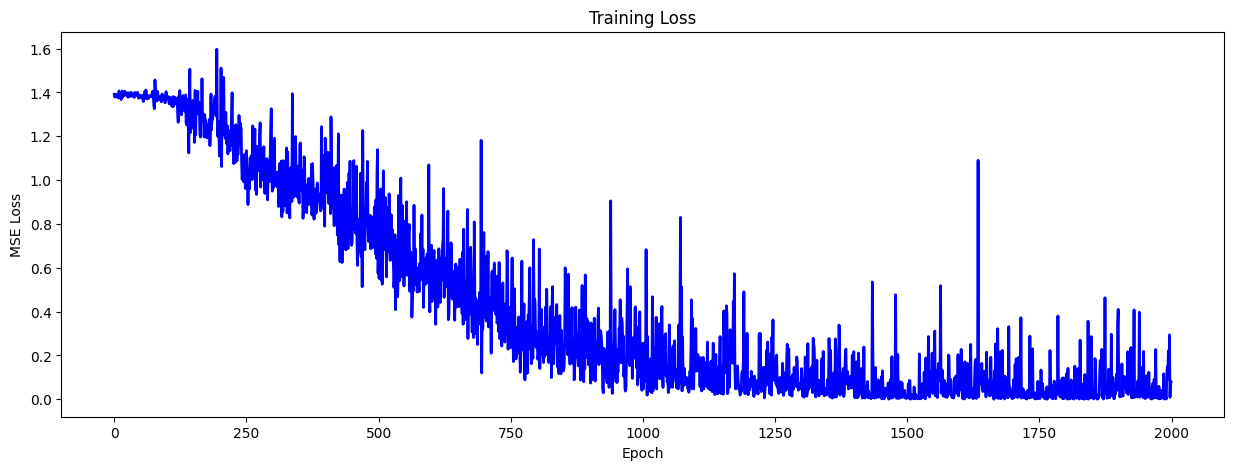

In [17]:
losses_300 = train(model=model_300, train_loader=train_loader_300, optimizer=optimizer_300, criterion=criterion, n_epochs=EPOCHS)

plt.figure(figsize=(15, 5))
plt.plot(losses_300, lw=2,color='blue')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

# Save the trained model
PATH = './model_300.pth'
torch.save(model_300.state_dict(), PATH)

C:\Users\gabri\AppData\Local\Temp\ipykernel_23012\3775393825.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_original.load_state_dict(torch.load('model_original.pt

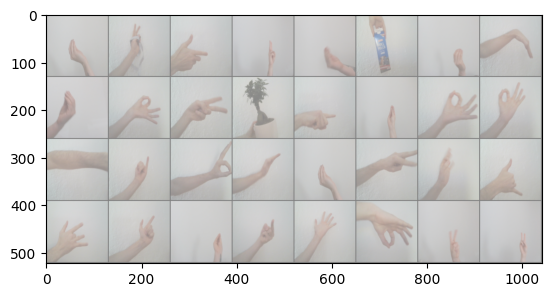

In [18]:
model_original.load_state_dict(torch.load('model_original.pth'))

# Check the testset
dataiter = iter(test_loader_original)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)

# print images
imshow(torchvision.utils.make_grid(images.cpu()))


# Resnet

In [7]:
from torchvision import models
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = 4  # For CIFAR-10

# Load ResNet18
model_resnet = models.resnet18(pretrained=True).to(device)


/home/andiv/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/andiv/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# Prevent the trained weights from being modified
for name, param in model_resnet.named_parameters():
  if 'fc' not in name: # Adjust this condition to target specific layers if needed
    param.requires_grad = False


# Compute the input feature size for the first fc layer
num_ftrs_resnet = model_resnet.fc.in_features
print(num_ftrs_resnet)

# Create a new set of fc layers
classifier = [
    nn.Linear(in_features=num_ftrs_resnet, out_features=256).to(device),
    nn.ReLU(inplace=True).to(device),
    nn.Dropout(p=0.3, inplace=False).to(device),
    nn.Linear(in_features=256, out_features=4, bias=True).to(device)
]

model_resnet.fc = nn.Sequential(*classifier).to(device) # Replace the model classifier

512


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer_resnet = torch.optim.Adam(model_resnet.parameters(), lr=0.001)

In [15]:
def train_resnet(model_resnet, train_loader, optimizer_resnet, criterion, n_epochs):
    losses = []
    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
                    
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = inputs.float()

            # zero the parameter gradients
            optimizer_resnet.zero_grad()

            # forward + backward + optimize
            outputs = model_resnet(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer_resnet.step()

            losses.append(loss.item())
            # print statistics
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}, loss: {running_loss / len(train_loader)}")
    return losses 

In [10]:
# Check the accuracy of the finetuned network on the test set
def test_resnet(model_resnet, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            images = images.float()
            outputs = model_resnet(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on test images with ResNet and a slightly modified classifier: %d %%' % (
        100 * correct / total))

In [17]:

losses = train_resnet(model_resnet, train_loader_200, optimizer_resnet, criterion, n_epochs=50)


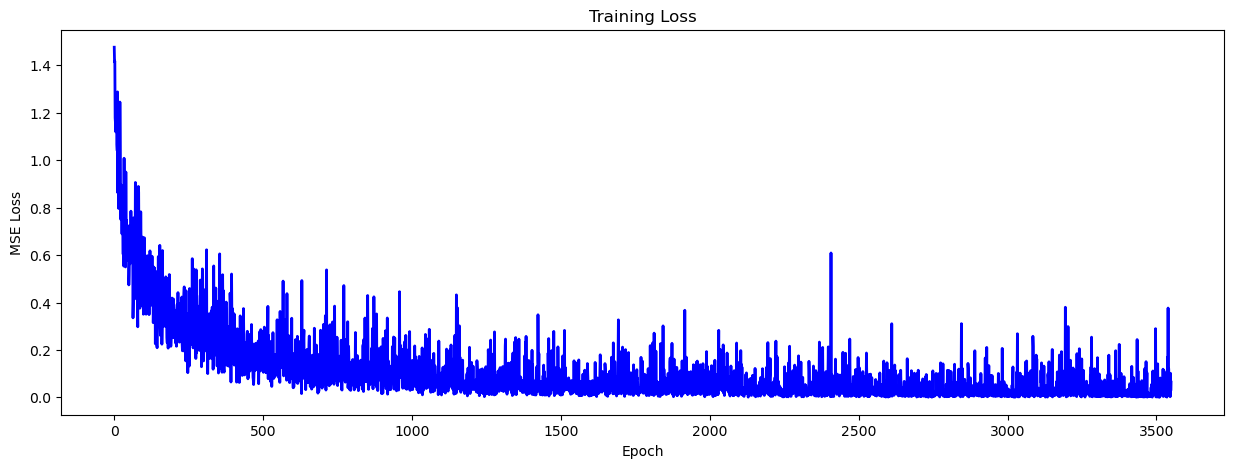

In [18]:
plt.figure(figsize=(15, 5))
plt.plot(losses, lw=2,color='blue')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

# Save the trained model
PATH = './resnet.pth'
torch.save(model_resnet.state_dict(), PATH)

In [11]:
# load the model 
model_resnet.load_state_dict(torch.load('resnet.pth')) 

# Test the ResNet model
test_resnet(model_resnet, test_loader_original)

/tmp/ipykernel_94762/439065298.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_resnet.load_state_dict(torch.load('resnet.pth'))


Accuracy of the network on test images with ResNet and a slightly modified classifier: 94 %


# Evaluation

In [20]:
def test_accuracy(model, test_loader, device='cpu'):
    """
    Calculate and return the accuracy of the model on the test set.

    Parameters:
    - model: The trained PyTorch model
    - test_loader: DataLoader for the test dataset
    - device: The device ('cpu' or 'cuda') on which the model and data reside

    Returns:
    - accuracy: Overall accuracy of the model on the test set (in percentage)
    """
    correct = 0
    total = 0
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # Disable gradient computation
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            images = images.float()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Compute overall accuracy
    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the test images: {accuracy:.2f} %')
    return accuracy


In [21]:
# Calculate the overall accuracy
print("Model original")
overall_accuracy_original = test_accuracy(model_original, test_loader_original, device=device)

print("Model 100")
overall_accuracy_100 = test_accuracy(model_100, test_loader_original, device=device)

print("Model 200")
overall_accuracy_200 = test_accuracy(model_200, test_loader_original, device=device)

print("Model 300")
#overall_accuracy_300 = test_accuracy(model_300, test_loader_original, device=device)



Model original
Accuracy of the network on the test images: 27.43 %
Model 100
Accuracy of the network on the test images: 86.73 %
Model 200
Accuracy of the network on the test images: 90.27 %
Model 300


In [22]:
def accuracy(model, test_loader, classes, device='cpu'):
    """
    Calculate and print the accuracy for each class.

    Parameters:
    - model: The trained PyTorch model
    - test_loader: DataLoader for the test dataset
    - classes: List of class names
    - device: The device ('cpu' or 'cuda') on which the model and data reside

    Returns:
    - class_accuracies: A dictionary with class names as keys and accuracy percentages as values
    """
    # Switch the model to evaluation mode
    model.eval()

    # Initialize variables for correct and total counts per class
    class_correct = list(0. for _ in range(len(classes)))
    class_total = list(0. for _ in range(len(classes)))

    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            images = images.float()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i].item()
                class_correct[label] += c[i].item()
                class_total[label] += 1

    # Compute and print accuracy for each class
    class_accuracies = {}
    for i in range(len(classes)):
        if class_total[i] > 0:  # Check to avoid division by zero
            accuracy = 100 * class_correct[i] / class_total[i]
            print(f'Accuracy of {classes[i]} : {accuracy:.2f} %')
            class_accuracies[classes[i]] = accuracy
        else:
            print(f'Accuracy of {classes[i]} : No samples available')
            class_accuracies[classes[i]] = None

    return class_accuracies


In [29]:
# Call the accuracy function
print("Model original")
class_accuracies = accuracy(model_original, test_loader_original, classes, device=device)

print("Model 100")
class_accuracies_100 = accuracy(model_100, test_loader_original, classes, device=device)

print("Model 200")
class_accuracies_200 = accuracy(model_200, test_loader_original, classes, device=device)

#print("Model 300")
#class_accuracies_300 = accuracy(model_300, test_loader_original, classes, device=device)


print("Model Resnet and Augmentation")
class_accuracies_resnet = accuracy(model_resnet, test_loader_original, classes, device=device)


Model original
Accuracy of checazzo : 100.00 %
Accuracy of peace : 0.00 %
Accuracy of nice : 0.00 %
Accuracy of nogesture : 0.00 %
Model 100
Accuracy of checazzo : 100.00 %
Accuracy of peace : 84.85 %
Accuracy of nice : 92.00 %
Accuracy of nogesture : 66.67 %
Model 200
Accuracy of checazzo : 100.00 %
Accuracy of peace : 84.85 %
Accuracy of nice : 100.00 %
Accuracy of nogesture : 75.00 %
Model Resnet and Augmentation
Accuracy of checazzo : 100.00 %
Accuracy of peace : 93.94 %
Accuracy of nice : 96.00 %
Accuracy of nogesture : 87.50 %


In [24]:
from sklearn.metrics import f1_score

def calculate_f1_score(y_true, y_pred, average='weighted'):
    """
    Calculate the F1 score for a classification problem.

    Parameters:
    - y_true: List or array of true class labels
    - y_pred: List or array of predicted class labels
    - average: The averaging method ('micro', 'macro', or 'weighted')

    Returns:
    - f1: F1 score (float)
    """
    f1 = f1_score(y_true, y_pred, average=average)
    print(f"F1 Score ({average}): {f1:.2f}")
    return f1


In [25]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to evaluate and visualize results
def evaluate_model(model, test_loader, label_map, device='cpu',average='weighted'):
    """
    Evaluate the model on a test set and visualize the results.

    Parameters:
    - model: The trained PyTorch model
    - test_loader: DataLoader for the test dataset
    - label_map: Dictionary mapping class indices to class names
    - device: The device ('cpu' or 'cuda') on which the model and data reside

    Returns:
    - accuracy: Overall accuracy of the model on the test set (in percentage)
    - conf_matrix: Confusion matrix of the test set predictions
    """
    model.eval()  # Set the model to evaluation mode

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            images = images.float()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())  # Collect predictions
            all_labels.extend(labels.cpu().numpy())  # Collect true labels

    # Compute accuracy
    correct = sum(p == l for p, l in zip(all_preds, all_labels))
    total = len(all_labels)
    accuracy = 100 * correct / total

    #Compute F1 score
    f1 = calculate_f1_score(all_labels, all_preds, average=average)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Print accuracy
    print(f"Accuracy of the network on the test set: {accuracy:.2f}%")

    # Visualize confusion matrix
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", 
                xticklabels=label_map.values(), 
                yticklabels=label_map.values())
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy, conf_matrix, f1


Model original
F1 Score (weighted): 0.12
Accuracy of the network on the test set: 27.43%


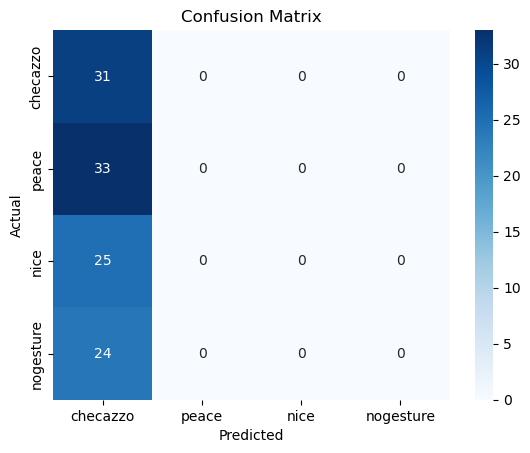

Model 100
F1 Score (weighted): 0.86
Accuracy of the network on the test set: 86.73%


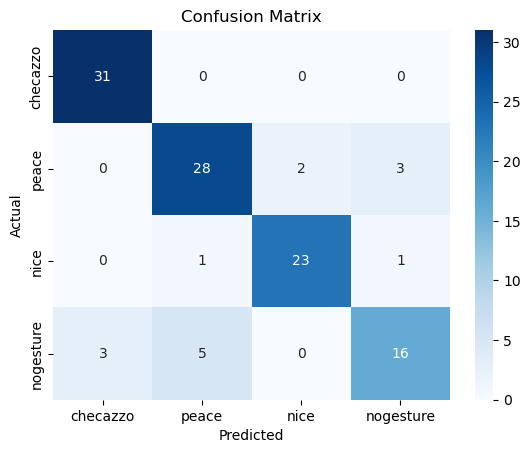

Model 200
F1 Score (weighted): 0.90
Accuracy of the network on the test set: 90.27%


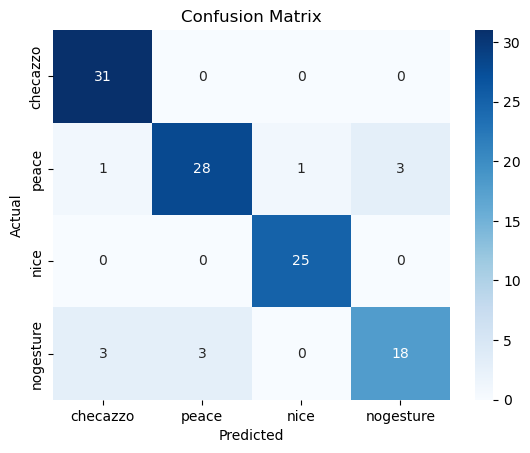

Model Resnet
F1 Score (weighted): 0.95
Accuracy of the network on the test set: 94.69%


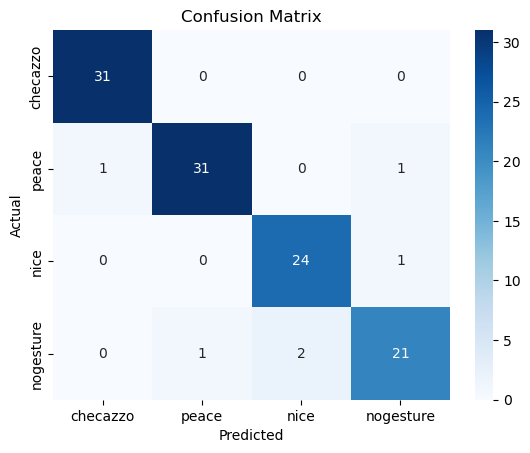

In [30]:
# Define the label map
label_map = {i: class_name for i, class_name in enumerate(classes)}

# Evaluate the model
print("Model original")
overall_accuracy, confusion_mat, f1 = evaluate_model(model_original, test_loader_original, label_map, device=device,average='weighted')

print("Model 100")
overall_accuracy_100, confusion_mat_100, f1_100 = evaluate_model(model_100, test_loader_original, label_map, device=device,average='weighted')

print("Model 200")
overall_accuracy_200, confusion_mat_200, f1_200 = evaluate_model(model_200, test_loader_original, label_map, device=device,average='weighted')

#print("Model 300")
#overall_accuracy_300, confusion_mat_300, f1_300 = evaluate_model(model_300, test_loader_original, label_map, device=device,average='weighted')

print("Model Resnet")
overall_accuracy_resnet, confusion_mat_resnet, f1_resnet = evaluate_model(model_resnet, test_loader_original, label_map, device=device,average='weighted')


# Demo

In [ ]:
import cv2
import torch
import torchvision.transforms as transforms
from PIL import Image



count = 0
#model_test = Net()
#model_test.load_state_dict(torch.load('model_300.pth'))
model_test = model_resnet 
#model_test = model_200

model_test.eval()
print(model_test)
cap = cv2.VideoCapture(0)

transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert OpenCV frame to PIL Image
    transforms.Resize((128, 128)),  # Resize to match model input
    transforms.ToTensor(),  # Convert to Tensor
])


while(True):
    ret, frame = cap.read()
    cv2.imshow("Live Video", frame)


    if(cv2.waitKey(1) & 0xFF == ord('c')):
        count += 1
        #cv2.imwrite(f"dataset/gesture_1/gesture_1_{count}.jpg", frame)
        img = cv2.resize(frame, (128, 128))
        print(img.shape)
        frame = np.transpose(img, (2, 0, 1))  # Reshape to (channels, height, width)
        imshow(frame)
        # cv2.imwrite(f"dataset/liveDemo/{count}.jpg", frame)


        # Preprocess the frame
        processed_frame = transform(frame).unsqueeze(0)  # Add batch dimension
        
        # Predict the label
        with torch.no_grad():  # No gradient calculation
            output = model_test(processed_frame)
            print(output)
            imshow(processed_frame.squeeze(0))
            predicted_label = torch.argmax(output, dim=1).item()  # Get the predicted label


        class_map = {0: 'CheCazzo', 1: 'Peace', 2: 'Nice', 3: 'No Gesture'}
        print(f"Predicted label: {class_map[predicted_label]}") 




    if(cv2.waitKey(1) & 0xFF == ord('q')):
        cap.release()
        cv2.destroyAllWindows()
        break

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'